## Tic-Tac-Toe Agent
​
In this notebook, we build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:

- Defining epsilon-greedy strategy

- Tracking state-action pairs for convergence
        
- Define hyperparameters for the Q-learning algorithm

- Generating episode and applying Q-update equation

- Checking convergence in Q-values

#### Importing libraries



In [1]:
# TCGame_Env.py is the MDP for the game env
from TCGame_Env import TicTacToe


import collections
import numpy as np
import random
import pickle
import time

from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state_key = Q_state(state)
    
    valid_act = valid_actions(state)
    if state_key not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state_key][action]=0

In [5]:
def loadQ(): # load table
        with open("Policy" + '.pkl', 'rb') as handle:
            Q_dict = pickle.load(handle)

## Epsilon-greedy strategy 



In [6]:
def eps_decay(episode):
    """ Use an exponential decay allowing more exploration at start, 
    and more exploitation towards the end of training"""
    
    # Use the decay factor as a function of number of episodes
    # This allows us to experiment with episodes without having to update decay factor every time 
    decay=1/EPISODES*5
    return(MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-decay*episode))

In [7]:
# Defining epsilon-greedy policy. 

def epsilon_greedy(state, step):
    epsilon = eps_decay(step)
    
    z = np.random.random()
        
    if z > epsilon:
        # Exploitation mode - Get action with max q-value for the current state
        state_key = Q_state(state)
        action = max(Q_dict[state_key],key=Q_dict[state_key].get)   
    else:
        # Exploration mode - Randomly choose an action from RL agent's action space
        # First object returned from env.action_space is for RL agent      
        action = random.choice([act for act in env.action_space(state)[0]])
    
    return action




#### Tracking the state-action pairs for checking convergence - write your code here

In [8]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

Tracking state, action pairs below
<pre>
1. 
X X X                     X X X
X X X --> action(4,5) --> X 5 X
X X X                     X X X

2. 
X X X                     X 9 X
X X X --> action(1,9) --> X X X
X X X                     X X X

3. 
X X X                     X X X
X 5 2 --> action(8,7) --> X 5 2
X X X                     X X 7

4. 
1 X X                     1 X X
X 8 X --> action(7,5) --> X 8 X
X X X                     X 5 X
</pre>

In [9]:
# Initialise states to be tracked
def initialise_tracking_states():
    track_state_action = [('x-x-x-x-x-x-x-x-x',(4,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-x-x-x-5-2-x-x-x',(8,7)),('1-x-x-x-8-x-x-x-x',(7,5))]    
    for tsa in track_state_action:
        state = tsa[0]
        action = tsa[1]
        States_track[state][action] = []

In [10]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

#### Define hyperparameters  

In [13]:
# Define parameters to be used 
EPISODES = 1000000
LR = 0.001
GAMMA = 0.9

MAX_EPSILON = 1.0
MIN_EPSILON = 0.001

TRACK_EPISODES=200
QSAVE_EPISODES=500


### Epsilon - decay check

In [14]:

episode = np.arange(0,EPISODES)
epsilon = []
for i in range(0,EPISODES):
    epsilon.append(eps_decay(i))

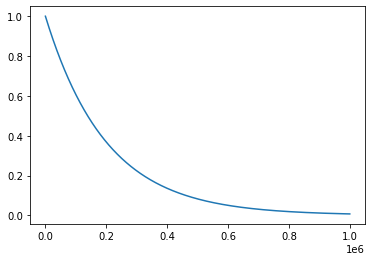

In [15]:
plt.plot(episode, epsilon)
plt.show()

### Q-update loop 

In [39]:
start_time = time.time()

env = TicTacToe()

for episode in range(EPISODES):
    
    # Reset board position to start game
    env.reset()
    
    curr_state = env.state    
    add_to_dict(curr_state)  
    game_over = False

    while not game_over:  
        curr_state_key = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)  
        next_state, reward, game_over = env.step(curr_state, curr_action) 
        next_state_key = Q_state(next_state)
        add_to_dict(next_state)  

        # Updating rules
        if not game_over:
            
            # action corresponding to max q-value in new state
            max_next = max(Q_dict[next_state_key],key=Q_dict[next_state_key].get)  
                
            Q_dict[curr_state_key][curr_action] += LR * ((reward + 
                                                          (GAMMA * (Q_dict[next_state_key][max_next])))
                                                           - Q_dict[curr_state_key][curr_action] ) 
        else:
            # For terminal state, there is no next state.
            Q_dict[curr_state_key][curr_action] += LR * ((reward - Q_dict[curr_state_key][curr_action]))

        # Move to next state
        curr_state = next_state
        
    # 
    if ((episode+1)%TRACK_EPISODES)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')
        
    if ((episode+1)% QSAVE_EPISODES) == 0:  
        save_obj(Q_dict,'Policy')  
        print (">", end="")
    
    if ((episode+1)% 100000) == 0:  
        elapsed_time = time.time() - start_time
        print ("\n",episode, " in ", elapsed_time)
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 99999  in  1278.6198139190674
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 199999  in  2869.215516090393
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 299999  in  4323.738987207413
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 399999  in  5783.598236083984
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Please note that I had run this iteration twice, for a total of 2,000,000 episodes. 

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [40]:
print ("Total time for",EPISODES,"episodes",elapsed_time)

Total time for 1000000 episodes 15212.6847178936


<function matplotlib.pyplot.show(*args, **kw)>

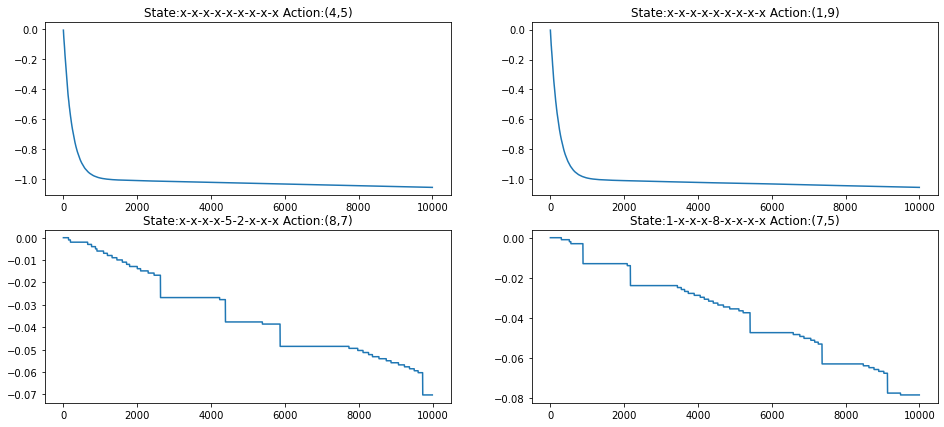

In [41]:
plt.figure(0, figsize=(16,7))

x_axis = list(range(len(States_track['x-x-x-x-x-x-x-x-x'][(4,5)])))
plt.subplot(221)
plt.plot(x_axis,States_track['x-x-x-x-x-x-x-x-x'][(4,5)])
plt.title("State:x-x-x-x-x-x-x-x-x Action:(4,5)")
plt.show

x_axis = list(range(len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(222)
plt.plot(x_axis,States_track['x-x-x-x-x-x-x-x-x'][(1,9)])
plt.title("State:x-x-x-x-x-x-x-x-x Action:(1,9)")


plt.show

x_axis = list(range(len(States_track['x-x-x-x-5-2-x-x-x'][(8,7)])))
plt.subplot(223)
plt.plot(x_axis,States_track['x-x-x-x-5-2-x-x-x'][(8,7)])
plt.title("State:x-x-x-x-5-2-x-x-x Action:(8,7)")


plt.show

x_axis = list(range(len(States_track['1-x-x-x-8-x-x-x-x'][(7,5)])))
plt.subplot(224)
plt.plot(x_axis,States_track['1-x-x-x-8-x-x-x-x'][(7,5)])
plt.title("State:1-x-x-x-8-x-x-x-x Action:(7,5)")


plt.show



From the plots we can see that state action pairs that appear earlier in the game have converged to a constant value, the ones appearing later in the game, is also converged to some extent with slight variations to the value. 
This indicate we may need to run more episodes to get a full convergence similar to early states. 

#### Check the Q-dictionary

In [42]:
len(Q_dict)

2189129

try checking for one of the states - that which action your agent thinks is the best.

In [44]:
max(Q_dict['x-9-x-x-2-x-x-x-x'],key=Q_dict['x-9-x-x-2-x-x-x-x'].get)  

(7, 5)

This is the right move, otherwise env could potentially win in the next move with a (7,4). Let's see Q values for all actions at this state.

In [54]:
Q_dict['x-9-x-x-2-x-x-x-x']

{(0, 1): -0.07823078945908474,
 (0, 3): -0.08438023339830353,
 (0, 5): -0.08252695148170319,
 (0, 7): -0.07811777091298044,
 (2, 1): -0.07825787364386419,
 (2, 3): -0.0778527190765509,
 (2, 5): -0.0822031158853007,
 (2, 7): -0.07784194993785189,
 (3, 1): -0.07835733754535792,
 (3, 3): -0.07769805206900977,
 (3, 5): -0.07849876884247695,
 (3, 7): -0.07913194641339802,
 (5, 1): -0.08711229235908022,
 (5, 3): -0.0778830482447387,
 (5, 5): -0.07802387883563827,
 (5, 7): -0.08098343227250814,
 (6, 1): -0.07813987752004849,
 (6, 3): -0.07780064094249595,
 (6, 5): -0.07895560501290133,
 (6, 7): -0.08522806070292271,
 (7, 1): -0.07842598311581177,
 (7, 3): -0.07780512946746294,
 (7, 5): -0.07769548654612947,
 (7, 7): -0.07834926512713451,
 (8, 1): -0.07819827090047564,
 (8, 3): -0.0778727805119738,
 (8, 5): -0.08553680873423691,
 (8, 7): -0.07773249157204776}

#### Final Q table 

In [48]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.0533148666502874,
              (0, 3): -1.0533145790680607,
              (0, 5): -1.0533153703726554,
              (0, 7): -1.0533176771136834,
              (0, 9): -1.0533173130254507,
              (1, 1): -1.0533139279489567,
              (1, 3): -1.0533138744048656,
              (1, 5): -1.0533178105197645,
              (1, 7): -1.0533203752996114,
              (1, 9): -1.0533206570559601,
              (2, 1): -1.053319733960757,
              (2, 3): -1.0533158726002392,
              (2, 5): -1.0533183461491524,
              (2, 7): -1.0533215995980592,
              (2, 9): -1.0533311682341198,
              (3, 1): -1.053316486115584,
              (3, 3): -1.0533165960216633,
              (3, 5): -1.053321645127289,
              (3, 7): -1.0533209767141047,
              (3, 9): -1.0533247966198087,
              (4, 1): -1.0533214900559489,
              (4, 3): -1.0533171246070954,
              (4, 